In [23]:
import pandas as pd
from pandas.io.json import json_normalize

import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Reading Data From Binance
🔗 Source: https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data

Getting M5 and M1 to DataFrame

In [25]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df_binance_bnbusdt_5m = pd.read_json(url_binance_bnbusdt_5m)

df_binance_bnbusdt_5m.columns = [
    '5m_open_time', 
    '5m_open_price', 
    '5m_high_price', 
    '5m_low_price', 
    '5m_close_price', 
    '5m_volume', 
    '5m_close_time', 
    '5m_quote_asset_volume', 
    '5m_number_of_trades', 
    '5m_taker_buy_base_asset_volume', 
    '5m_taker_buy_quote_asset_volume', 
    '5m_unused'
]

df_binance_bnbusdt_5m.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,5m_unused
0,1665279900000,276.3,276.6,276.2,276.6,444.204,1665280199999,122780.5390,213,383.284,105944.8671,0
1,1665280200000,276.6,276.6,276.1,276.3,551.117,1665280499999,152302.8206,361,223.513,61763.6827,0
2,1665280500000,276.3,276.6,276.2,276.6,435.701,1665280799999,120436.6941,248,399.158,110335.4526,0
3,1665280800000,276.5,276.9,276.5,276.8,631.086,1665281099999,174622.5932,324,477.410,132097.8852,0
4,1665281100000,276.8,276.9,276.7,276.9,123.217,1665281399999,34110.0706,184,74.998,20763.3399,0


In [26]:
url_binance_bnbusdt_1m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=1m"
df_binance_bnbusdt_1m = pd.read_json(url_binance_bnbusdt_1m)

df_binance_bnbusdt_1m.columns = [
    '1m_open_time', 
    '1m_open_price', 
    '1m_high_price', 
    '1m_low_price', 
    '1m_close_price', 
    '1m_volume', 
    '1m_close_time', 
    '1m_quote_asset_volume', 
    '1m_number_of_trades', 
    '1m_taker_buy_base_asset_volume', 
    '1m_taker_buy_quote_asset_volume', 
    '1m_unused'
]

df_binance_bnbusdt_1m.head()

,1m_open_time,1m_open_price,1m_high_price,1m_low_price,1m_close_price,1m_volume,1m_close_time,1m_quote_asset_volume,1m_number_of_trades,1m_taker_buy_base_asset_volume,1m_taker_buy_quote_asset_volume,1m_unused
0,1665519840000,270.7,270.9,270.7,270.9,30.937,1665519899999,8379.9908,49,23.224,6291.3229,0
1,1665519900000,270.8,270.9,270.7,270.8,52.975,1665519959999,14343.3267,62,6.169,1670.7281,0
2,1665519960000,270.7,270.8,270.7,270.7,47.756,1665520019999,12930.8035,72,32.543,8812.6444,0
3,1665520020000,270.7,270.9,270.7,270.9,64.837,1665520079999,17560.4501,72,47.968,12992.8246,0
4,1665520080000,270.9,271.0,270.8,271.0,21.915,1665520139999,5937.8945,79,16.000,4335.6035,0


In [27]:
len(df_binance_bnbusdt_5m), len(df_binance_bnbusdt_1m)

(1000, 1000)

### Reading Rounds Data from Pancake Subgraph
🔗 Source: https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2

Method: `POST`

Query:

{ query: "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) {
    id
    epoch
    position
    failed
    startAt
    startBlock
    startHash
    lockAt
    lockBlock
    lockHash
    lockPrice
    lockRoundId
    closeAt
    closeBlock
    closeHash
    closePrice
    closeRoundId
    totalBets
    totalAmount
    bullBets
    bullAmount
    bearBets
    bearAmount
    }
}", }

In [28]:
pancake_subgraph_url = 'https://api.thegraph.com/subgraphs/name/pancakeswap/prediction-v2'
pancake_rounds_query = '{"query": "{ rounds(first: 1000 where: {position_not: null} orderBy: epoch,orderDirection:desc) { id epoch position failed startAt startBlock startHash lockAt lockBlock lockHash lockPrice lockRoundId closeAt closeBlock closeHash closePrice closeRoundId totalBets totalAmount bullBets bullAmount bearBets bearAmount } }"}'

In [29]:
import requests
req_pancake_rounds = requests.post(url=pancake_subgraph_url, data=pancake_rounds_query)

In [31]:
req_pancake_rounds

<Response [200]>

In [32]:
json_pancake_rounds = req_pancake_rounds.json()

In [33]:
len(json_pancake_rounds["data"]["rounds"])

1000

In [34]:
df_pancake_rounds = pd.DataFrame.from_dict(json_pancake_rounds["data"]["rounds"])

In [35]:
df_pancake_rounds.head()

,id,epoch,position,failed,startAt,startBlock,startHash,lockAt,lockBlock,lockHash,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,111539,111539,Bear,False,1665578983,22111918,0x9021d8c14cc89ca767232c6436ef5e204aa9e3077c6d...,1665579292,22112021,0x5a39b16ff25b1fb2f0048718ec71ddda9d161c06db44...,...,22112122,0xd65a8f4d4d8daeffb6e745a41a688be36258110a6eea...,270.36,18446744073711491841,89,20.24191375037382029,35,4.538054498334457712,54,15.703859252039362578
1,111538,111538,Bear,False,1665578674,22111815,0xa371768aba99a2af133d55f3ff60424f51c5bf5e483a...,1665578983,22111918,0x9021d8c14cc89ca767232c6436ef5e204aa9e3077c6d...,...,22112021,0x5a39b16ff25b1fb2f0048718ec71ddda9d161c06db44...,270.47405632,18446744073711491825,84,19.612701088217058371,39,5.826322966049102096,45,13.786378122167956275
2,111537,111537,Bear,False,1665578365,22111712,0xb6faaee2d538016f5c08428ad6f819293bed0fd993ab...,1665578674,22111815,0xa371768aba99a2af133d55f3ff60424f51c5bf5e483a...,...,22111918,0x9021d8c14cc89ca767232c6436ef5e204aa9e3077c6d...,270.74217346,18446744073711491812,87,19.170000508987134681,35,7.34774651562136126,52,11.822253993365773421
3,111536,111536,Bull,False,1665578056,22111609,0x9a4452376d34eefa77b8f196273588eef280a4fc216c...,1665578365,22111712,0xb6faaee2d538016f5c08428ad6f819293bed0fd993ab...,...,22111815,0xa371768aba99a2af133d55f3ff60424f51c5bf5e483a...,271.00983893,18446744073711491797,82,15.038837297926086557,44,10.378373504511289481,38,4.660463793414797076
4,111535,111535,Bear,False,1665577741,22111504,0x72afbdd6d48640d19ef4494ebf364fcdc1ca4e50a3d9...,1665578056,22111609,0x9a4452376d34eefa77b8f196273588eef280a4fc216c...,...,22111712,0xb6faaee2d538016f5c08428ad6f819293bed0fd993ab...,270.36,18446744073711491782,91,16.023296154873738098,58,8.747247450574583378,33,7.27604870429915472


In [36]:
# Create a key-column to join DataFrames
df_binance_bnbusdt_5m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_5m["5m_close_time"], unit='ms')
df_binance_bnbusdt_1m["timestamp_key"] = pd.to_datetime(df_binance_bnbusdt_1m["1m_close_time"], unit='ms')
df_pancake_rounds["timestamp_key"] = pd.to_datetime(df_pancake_rounds["closeAt"], unit='s')

# Sort by join key
df_binance_bnbusdt_5m.sort_values('timestamp_key', inplace=True)
df_binance_bnbusdt_1m.sort_values('timestamp_key', inplace=True)
df_pancake_rounds.sort_values('timestamp_key', inplace=True)

In [38]:
# Join Dataframes
df_joined = pd.merge_asof(df_binance_bnbusdt_5m, df_pancake_rounds, on='timestamp_key',direction = 'nearest', tolerance=pd.Timedelta("5 min"))

# Remove Empty epoch column records
df_joined.dropna(subset=['epoch'], inplace=True)

df_joined.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,1665279900000,276.3,276.6,276.2,276.6,444.204,1665280199999,122780.5390,213,383.284,...,22013919,0x7e48898395bbd7f66e2290b706a7e2a3178927dc295f...,276.53967209,18446744073711477926,76,13.964041840697801644,42,8.186798625509371214,34,5.77724321518843043
1,1665280200000,276.6,276.6,276.1,276.3,551.117,1665280499999,152302.8206,361,223.513,...,22014022,0x1d6c0cdb2074abe51c3d5a739a41f8dffbc3f11d7842...,276.51421268,18446744073711477938,70,12.916413917929490505,47,6.732423279447043889,23,6.183990638482446616
2,1665280500000,276.3,276.6,276.2,276.6,435.701,1665280799999,120436.6941,248,399.158,...,22014126,0x732a481991dff54574b6698dd996721988328b4cf581...,276.73774627,18446744073711477954,78,14.327208748385245129,44,9.510715180918773806,34,4.816493567466471323
3,1665280800000,276.5,276.9,276.5,276.8,631.086,1665281099999,174622.5932,324,477.410,...,22014229,0x7c83055d5958c0e507f3978cfd0e1dae764467fd6314...,276.83898755,18446744073711477967,77,10.40769108999123668,39,6.589253479806989492,38,3.818437610184247188
4,1665281100000,276.8,276.9,276.7,276.9,123.217,1665281399999,34110.0706,184,74.998,...,22014332,0x938c42a7c5b27e55a16a144999ff874e73f8f077ba16...,276.82433672,18446744073711477981,83,13.513759438458121544,42,9.670375882932980689,41,3.843383555525140855


In [39]:
df_distinct = df_joined.drop_duplicates(['epoch'], keep='last')
df_distinct.head()

,5m_open_time,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_close_time,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,...,closeBlock,closeHash,closePrice,closeRoundId,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,1665279900000,276.3,276.6,276.2,276.6,444.204,1665280199999,122780.5390,213,383.284,...,22013919,0x7e48898395bbd7f66e2290b706a7e2a3178927dc295f...,276.53967209,18446744073711477926,76,13.964041840697801644,42,8.186798625509371214,34,5.77724321518843043
1,1665280200000,276.6,276.6,276.1,276.3,551.117,1665280499999,152302.8206,361,223.513,...,22014022,0x1d6c0cdb2074abe51c3d5a739a41f8dffbc3f11d7842...,276.51421268,18446744073711477938,70,12.916413917929490505,47,6.732423279447043889,23,6.183990638482446616
2,1665280500000,276.3,276.6,276.2,276.6,435.701,1665280799999,120436.6941,248,399.158,...,22014126,0x732a481991dff54574b6698dd996721988328b4cf581...,276.73774627,18446744073711477954,78,14.327208748385245129,44,9.510715180918773806,34,4.816493567466471323
3,1665280800000,276.5,276.9,276.5,276.8,631.086,1665281099999,174622.5932,324,477.410,...,22014229,0x7c83055d5958c0e507f3978cfd0e1dae764467fd6314...,276.83898755,18446744073711477967,77,10.40769108999123668,39,6.589253479806989492,38,3.818437610184247188
4,1665281100000,276.8,276.9,276.7,276.9,123.217,1665281399999,34110.0706,184,74.998,...,22014332,0x938c42a7c5b27e55a16a144999ff874e73f8f077ba16...,276.82433672,18446744073711477981,83,13.513759438458121544,42,9.670375882932980689,41,3.843383555525140855


In [40]:
# Exporting Data Frame
df_distinct.to_csv("dataset-to-predict.csv", index=False)

In [87]:
# Remove unused columns
df_predict = df_distinct.drop([
    '5m_open_time', 
    '5m_close_time', 
    '5m_unused', 
    'timestamp_key', 
    'id', 
    'epoch', 
    'failed', 
    'startAt', 
    'startBlock', 
    'startHash', 
    'lockAt', 
    'lockBlock', 
    'lockHash', 
    'lockRoundId', 
    'closeAt', 
    'closeBlock', 
    'closeHash', 
    'closeRoundId'], axis=1)


df_predict.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,position,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,276.3,276.6,276.2,276.6,444.204,122780.5390,213,383.284,105944.8671,Bull,276.33,276.53967209,76,13.964041840697801644,42,8.186798625509371214,34,5.77724321518843043
1,276.6,276.6,276.1,276.3,551.117,152302.8206,361,223.513,61763.6827,Bear,276.53967209,276.51421268,70,12.916413917929490505,47,6.732423279447043889,23,6.183990638482446616
2,276.3,276.6,276.2,276.6,435.701,120436.6941,248,399.158,110335.4526,Bull,276.51421268,276.73774627,78,14.327208748385245129,44,9.510715180918773806,34,4.816493567466471323
3,276.5,276.9,276.5,276.8,631.086,174622.5932,324,477.410,132097.8852,Bull,276.73774627,276.83898755,77,10.40769108999123668,39,6.589253479806989492,38,3.818437610184247188
4,276.8,276.9,276.7,276.9,123.217,34110.0706,184,74.998,20763.3399,Bear,276.83898755,276.82433672,83,13.513759438458121544,42,9.670375882932980689,41,3.843383555525140855


In [88]:
df_predict["lockPrice"] = pd.to_numeric(df_predict["lockPrice"])
df_predict["closePrice"] = pd.to_numeric(df_predict["closePrice"])
df_predict["totalBets"] = pd.to_numeric(df_predict["totalBets"])
df_predict["totalAmount"] = pd.to_numeric(df_predict["totalAmount"])
df_predict["bullBets"] = pd.to_numeric(df_predict["bullBets"])
df_predict["bullAmount"] = pd.to_numeric(df_predict["bullAmount"])
df_predict["bearBets"] = pd.to_numeric(df_predict["bearBets"])
df_predict["bearAmount"] = pd.to_numeric(df_predict["bearAmount"])
df_predict.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,position,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
0,276.3,276.6,276.2,276.6,444.204,122780.5390,213,383.284,105944.8671,Bull,276.330000,276.539672,76,13.964042,42,8.186799,34,5.777243
1,276.6,276.6,276.1,276.3,551.117,152302.8206,361,223.513,61763.6827,Bear,276.539672,276.514213,70,12.916414,47,6.732423,23,6.183991
2,276.3,276.6,276.2,276.6,435.701,120436.6941,248,399.158,110335.4526,Bull,276.514213,276.737746,78,14.327209,44,9.510715,34,4.816494
3,276.5,276.9,276.5,276.8,631.086,174622.5932,324,477.410,132097.8852,Bull,276.737746,276.838988,77,10.407691,39,6.589253,38,3.818438
4,276.8,276.9,276.7,276.9,123.217,34110.0706,184,74.998,20763.3399,Bear,276.838988,276.824337,83,13.513759,42,9.670376,41,3.843384


In [89]:
# Change position column to 0 or 1 column
df_predict["position_code"] = pd.Categorical(df_predict.position).codes
df_predict.drop("position", axis=1, inplace=True)

In [90]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ["5m_open_price", "5m_high_price", "5m_low_price", "5m_close_price", "5m_volume", "5m_quote_asset_volume", "5m_number_of_trades", "5m_taker_buy_base_asset_volume", "5m_taker_buy_quote_asset_volume", "lockPrice", "closePrice", "totalBets", "totalAmount", "bullBets", "bullAmount", "bearBets", "bearAmount"]), # turn all values in these columns between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), [])
)

In [91]:
# Create X & y values

# The X (independent variables) will be every column of DataFrame except charges
X = df_predict.drop("position_code", axis=1)

# The y (dependent or label) is charges column
y = df_predict["position_code"]

In [92]:
# Split dataset in random set to train using sklearn
# Separate 20% (0.2) for test and 80% to train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
X_train.head()

,5m_open_price,5m_high_price,5m_low_price,5m_close_price,5m_volume,5m_quote_asset_volume,5m_number_of_trades,5m_taker_buy_base_asset_volume,5m_taker_buy_quote_asset_volume,lockPrice,closePrice,totalBets,totalAmount,bullBets,bullAmount,bearBets,bearAmount
744,273.3,273.7,273.0,273.5,1355.648,370696.9922,718,962.781,263253.0916,273.091286,273.511331,86,9.717464,45,4.901123,41,4.816341
198,278.0,278.2,277.9,278.1,402.966,112071.8629,324,321.431,89398.5413,278.053171,278.156206,62,7.283322,39,4.381450,23,2.901872
976,271.9,271.9,271.8,271.9,415.975,113087.1964,459,251.914,68495.4166,271.945312,271.828689,77,13.174648,46,8.875258,31,4.299390
586,269.9,270.4,269.9,270.3,987.367,266766.3996,558,575.782,155566.4148,269.730000,270.012500,74,8.619362,43,5.234679,31,3.384683
465,274.1,274.3,274.0,274.0,796.417,218316.6562,528,260.322,71373.7923,273.864413,274.118892,65,8.691074,38,6.236763,27,2.454311


In [94]:
# Fit the column transformer to our training data
ct.fit(X_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['5m_open_price', '5m_high_price',
                                  '5m_low_price', '5m_close_price', '5m_volume',
                                  '5m_quote_asset_volume',
                                  '5m_number_of_trades',
                                  '5m_taker_buy_base_asset_volume',
                                  '5m_taker_buy_quote_asset_volume',
                                  'lockPrice', 'closePrice', 'totalBets',
                                  'totalAmount', 'bullBets', 'bullAmount',
                                  'bearBets', 'bearAmount']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'), [])])

In [95]:
# Transform training and test data with normalization (MinMaxScaler) and OneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [98]:
# What does our data look like now?
X_train.loc[0], X_train_normal[0]

(5m_open_price                         276.300000
 5m_high_price                         276.600000
 5m_low_price                          276.200000
 5m_close_price                        276.600000
 5m_volume                             444.204000
 5m_quote_asset_volume              122780.539000
 5m_number_of_trades                   213.000000
 5m_taker_buy_base_asset_volume        383.284000
 5m_taker_buy_quote_asset_volume    105944.867100
 lockPrice                             276.330000
 closePrice                            276.539672
 totalBets                              76.000000
 totalAmount                            13.964042
 bullBets                               42.000000
 bullAmount                              8.186799
 bearBets                               34.000000
 bearAmount                              5.777243
 Name: 0, dtype: float64,
 array([0.46428571, 0.47222222, 0.48333333, 0.47787611, 0.10884071,
        0.10843154, 0.11071143, 0.22430838, 0.22387497, 

In [368]:
# Build a neural network model to fit on our normalized data

tf.random.set_seed(42)

# 1. Create the model (based on insurance_model_2)
model_a = tf.keras.Sequential([
    tf.keras.layers.Dense(5, name="hidden_layer_1", activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, name="hidden_layer_2", activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, name="hidden_layer_3", activation=tf.keras.activations.relu),
    # tf.keras.layers.Dense(5, name="hidden_layer_3"),
    # tf.keras.layers.Dense(5, name="hidden_layer_4"),
    tf.keras.layers.Dense(1, name="output_layer")
], name="model_a")

# 2. Compile the model
model_a.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                          metrics=["mae"])

# 3. Fit the model
history_model_a = model_a.fit(X_train_normal, y_train, epochs=800, verbose=0)

In [369]:
model_a.summary()

Model: "model_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 5)                 90        
                                                                 
 hidden_layer_2 (Dense)      (None, 4)                 24        
                                                                 
 hidden_layer_3 (Dense)      (None, 4)                 20        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________


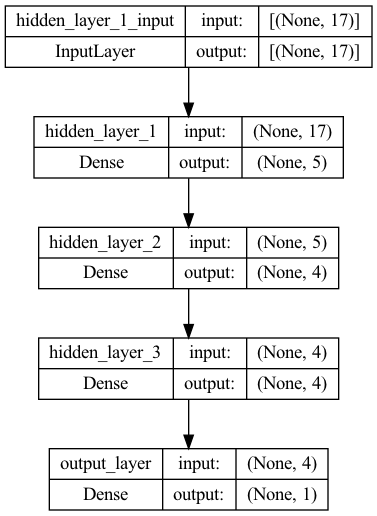

In [370]:
plot_model(model_a, show_shapes=True)

In [371]:
# Evaluate our insurance model trained on normalized data

model_a.evaluate(X_test_normal, y_test)

7/7 [==============================] - 0s 813us/step - loss: 0.1235 - mae: 0.1235


[0.12352057546377182, 0.12352057546377182]

### Best result
* 5 (relu) -> 4 (relu) -> 4 (relu) -> 1
* Adam(learning_rate: 0.001)
* Epochs: 800

0.1235

Text(0.5, 0, 'epochs')

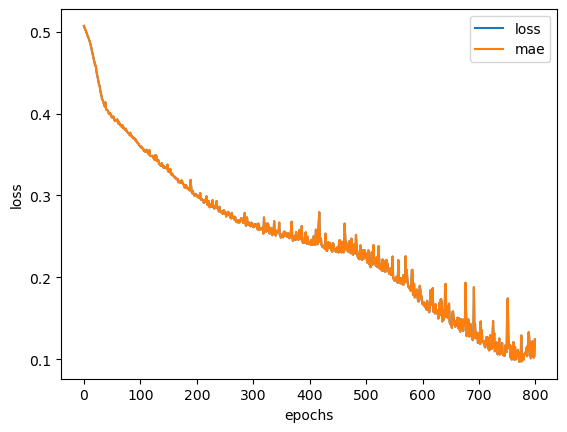

In [372]:
# Plot history (also known as a loss curve or training curve)
pd.DataFrame(history_model_a.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [373]:
# Save model using the SavedModel format
!mkdir -p saved_model
model_a.save('saved_model/prediction_linear_regression_model_a')

INFO:tensorflow:Assets written to: saved_model/prediction_linear_regression_model_a/assets


In [374]:
# Save model using the HDF5 format
!mkdir -p hdf5

# The '.h5' extension indicates that the model should be saved to HDF5
model_a.save('hdf5/prediction_linear_regression_model_a.h5')